In [4]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [5]:
df = pd.read_csv('mindvalley_tweets.csv')
df.rename(columns={"tweet":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,@octopus_energy I think your wheel is broken 🤣...
1,1,Our 3 stories of the week...\n\nNo 3: Kind cou...
2,2,@adamtranter Glad I jumped ship ages ago. Hope...
3,3,@newelland @octopus_energy I get that HRM is u...
4,4,@newelland @octopus_energy I've also wondered ...


In [6]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [7]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()

In [8]:
list_data = df.comments.unique().tolist()

In [9]:
len(list_data)

499

In [10]:
from sentence_transformers import SentenceTransformer

In [11]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [12]:
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [13]:
best_model = umap.UMAP(n_components=5).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

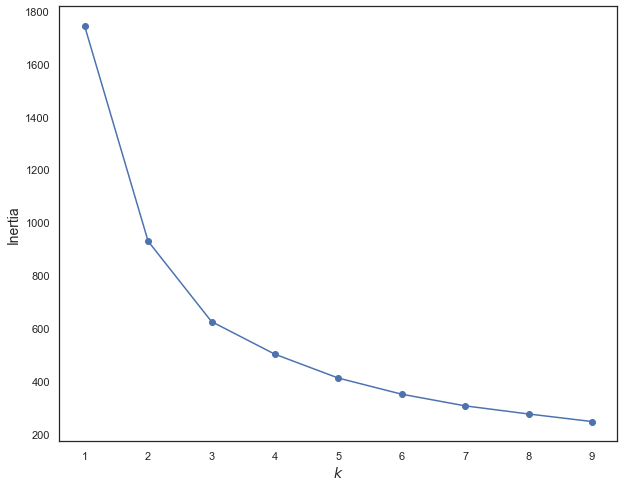

In [14]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [15]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [16]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [17]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [18]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Accent')
    plt.show()

{-1: 136, 0: 25, 1: 7, 2: 133, 3: 13, 4: 12, 5: 42, 6: 8, 7: 7, 8: 13, 9: 16, 10: 16, 11: 32, 12: 9, 13: 30}


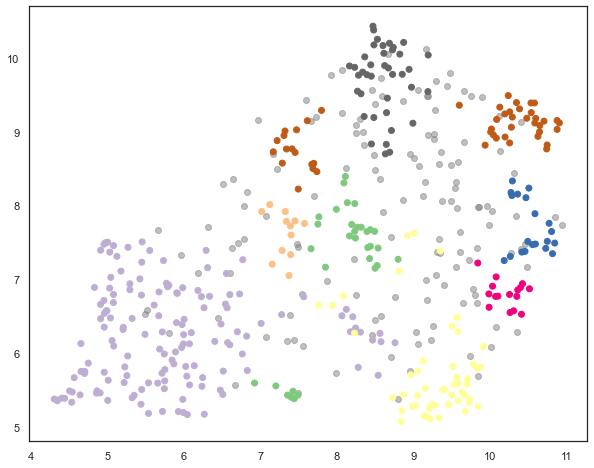

In [19]:
plot()

In [20]:
len(cluster)

499

In [23]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [24]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,I think your wheel be break l it hit and roll ...
1,0,octopus energy help natwest group customer swi...
2,1,I could listen to all day enthuse wildly about...
3,2,I get that hrm be use to exert control over em...
4,3,yeah I hear mostly good thing about they he be...
5,4,we ve be with they for a while brilliant compa...
6,5,love this I know we too and I encourage load o...
7,6,why be it so difficult to switch from you to I...
8,7,I just check online banking and it show a pend...
9,8,wonder if anyone be actually still work at day...


In [25]:
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('switch octopus', 0.5125), ('octopus toy', 0.507), ('toy octopus', 0.4822), ('nt octopusenergy', 0.4788), ('merge octopus', 0.4778), ('octopus octopi', 0.4772), ('energy octopus', 0.4749), ('octopus live', 0.4723), ('octopus app', 0.4698), ('octopus energy', 0.4678)]
   Bigram Cluster 2: 
[('podcast listen', 0.5941), ('good podcast', 0.5488), ('podcast interesting', 0.5442), ('interview podcast', 0.5268), ('podcast highly', 0.4809), ('today podcast', 0.4733), ('podcast global', 0.4619), ('watching listen', 0.4461), ('send podcast', 0.4364), ('amp podcast', 0.4355)]
   Bigram Cluster 3: 
[('like organisational', 0.4398), ('company tendency', 0.4221), ('personnel management', 0.402), ('company work', 0.4012), ('management ve', 0.4006), ('approach organizational', 0.3984), ('worker organisation', 0.3923), ('management team', 0.3896), ('work leadership', 0.3877), ('talent management', 0.3847)]
   Bigram Cluster 4: 
[('differ gorgeous', 0.4127), ('hear quite', 0.4073

In [26]:
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('octopus', 0.4588), ('octopusenergy', 0.4427), ('octopod', 0.4209), ('octopi', 0.4185), ('octoshine', 0.3887), ('octopusesese', 0.388), ('pet', 0.3194), ('poop', 0.3041), ('twitter', 0.2888), ('support', 0.2781)]
   Unigram Cluster 2: 
[('podcast', 0.4356), ('listen', 0.3095), ('interview', 0.2425), ('watching', 0.2368), ('electrification', 0.2292), ('technology', 0.2277), ('episode', 0.2245), ('tomorrow', 0.2217), ('session', 0.2206), ('interesting', 0.2183)]
   Unigram Cluster 3: 
[('organisational', 0.3968), ('organizational', 0.3895), ('corporate', 0.3427), ('organisation', 0.3425), ('management', 0.3425), ('employer', 0.3358), ('employment', 0.3183), ('employee', 0.3181), ('employ', 0.3132), ('failure', 0.3108)]
   Unigram Cluster 4: 
[('gorgeous', 0.3076), ('cheer', 0.2881), ('similar', 0.2723), ('buyer', 0.2719), ('quite', 0.269), ('hear', 0.2676), ('good', 0.2618), ('brilliant', 0.2571), ('differ', 0.2429), ('oooh', 0.2236)]
   Unigram Cluster 5: 
[('ex

In [27]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['octopus', 'octopusenergy', 'octopod', 'octopi', 'octoshine', 'octopusesese', 'pet', 'poop', 'twitter', 'support', 'switch octopus', 'octopus toy', 'nt octopusenergy', 'merge octopus', 'octopus octopi', 'energy octopus', 'octopus live', 'octopus app']
   Cluster 2: 
['podcast', 'listen', 'interview', 'watching', 'electrification', 'technology', 'episode', 'tomorrow', 'session', 'interesting', 'podcast listen', 'good podcast', 'podcast interesting', 'interview podcast', 'podcast highly', 'today podcast', 'podcast global', 'watching listen', 'send podcast', 'amp podcast']
   Cluster 3: 
['organisational', 'organizational', 'corporate', 'organisation', 'management', 'employer', 'employment', 'employee', 'employ', 'failure', 'like organisational', 'company tendency', 'personnel management', 'company work', 'management ve', 'approach organizational', 'worker organisation', 'management team', 'work leadership', 'talent management']
   Cluster 4: 
['gorgeous', 'cheer', 'simila